In [1]:
%gui tk
%matplotlib inline

import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
from skimage.io import imread
import re
import matplotlib.pyplot as plt

In [2]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [3]:
# Create a dataframe for images and coordinates
data_dir = os.path.normpath(filedialog.askdirectory())
all_images = glob(os.path.join(data_dir, '*', '*.tif'))
all_info = glob(os.path.join(data_dir, '*', '*.txt'))
img_df = pd.DataFrame({'img_path': all_images, 'info_path': all_info})
img_id = lambda in_path: in_path.split('\\')[-2][-6:]
img_df['ImageID'] = img_df['img_path'].map(img_id)

In [4]:
# define regular expressions to get coordinates
regexp_x = re.compile("x = ([0-9.]*),")
regexp_y = re.compile("y = ([0-9.]*)\n")

In [5]:
# function to read coordinates from text file
def read_and_parse_coordinates(info_file):
    file = open(info_file, "r")
    lines = file.readlines()
    x = []
    y = []
    for line in lines:
        xi = regexp_x.search(line)
        if xi:
            x.append(xi.group(1))
            y.append(regexp_y.search(line).group(1))
    file.close()
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)


In [66]:
def load_image(img_file):
    image = imread(img_file)
    image = np.stack([image,image,image], 2)
    return image

In [67]:
img_df['x_y_coordinates'] = img_df['info_path'].map(read_and_parse_coordinates)
img_df['images'] = img_df['img_path'].map(load_image)

In [68]:
print(img_df.sample(2))


                                               img_path  \
1344  C:\Users\smirnovm\Documents\Data\Labeled_Spine...   
142   C:\Users\smirnovm\Documents\Data\Labeled_Spine...   

                                              info_path ImageID  \
1344  C:\Users\smirnovm\Documents\Data\Labeled_Spine...  001345   
142   C:\Users\smirnovm\Documents\Data\Labeled_Spine...  000143   

                                        x_y_coordinates  \
1344  ([98.0, 58.0, 63.0, 95.0, 107.0, 86.0], [82.0,...   
142   ([16.0, 36.0, 63.0, 71.0], [92.0, 101.0, 71.0,...   

                                                 images  \
1344  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
142   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                                  boxes  
1344  [[83.0, 67.0, 113.0, 97.0], [43.0, 60.0, 73.0,...  
142   [[1.0, 77.0, 31.0, 107.0], [21.0, 86.0, 51.0, ...  


In [69]:
images = img_df['images'].as_matrix()
# np.savez('spine_images',images) #saved in a later cell

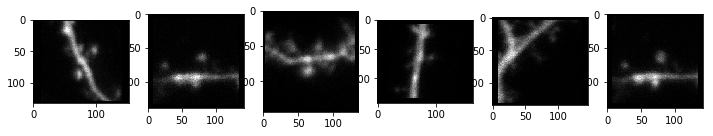

In [70]:
#Show a few sample images
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].sample(n_img), range(6)):
    m_axs[ax_ind].imshow(img)

plt.show(fig)

In [71]:
#show example set of coordinates
img_df['x_y_coordinates'].sample(2)


754     ([65.0, 45.0, 94.0, 82.0, 102.0], [97.0, 42.0,...
1727            ([93.0, 94.0, 75.0], [74.0, 109.0, 68.0])
Name: x_y_coordinates, dtype: object

In [72]:
#make boxes from given coordinates
BOX_WIDTH = 30 #px
BOX_HEIGHT = 30 #px

def coords_to_boxes(x_y_coordinates):
    #boxes is an array of shape (num_boxes,4) containing box corners as (y_min, x_min, y_max, x_max).
    boxes = []
    if x_y_coordinates:
        for x,y in zip(x_y_coordinates[0], x_y_coordinates[1]):
            box = np.array([x-BOX_WIDTH/2,y-BOX_WIDTH/2, x+BOX_WIDTH/2,y+BOX_WIDTH/2])
            boxes.append(box)
    return np.array(boxes)


In [73]:
#test on set of coordinates
coords_to_boxes(([38.0, 82.0, 65.0], [49.0, 51.0, 87.0]))

array([[ 23.,  34.,  53.,  64.],
       [ 67.,  36.,  97.,  66.],
       [ 50.,  72.,  80., 102.]])

In [74]:
#map all coordinates to boxes
img_df['boxes'] = img_df['x_y_coordinates'].map(coords_to_boxes)
#preview dataframe
img_df.sample(2)

,img_path,info_path,ImageID,x_y_coordinates,images,boxes
248,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000249,"([45.0, 55.0, 74.0], [145.0, 171.0, 122.0])","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[30.0, 130.0, 60.0, 160.0], [40.0, 156.0, 70...."
371,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000372,"([112.0, 100.0, 28.0, 57.0, 57.0], [75.0, 67.0...","[[[12, 12, 12], [14, 14, 14], [10, 10, 10], [9...","[[97.0, 60.0, 127.0, 90.0], [85.0, 52.0, 115.0..."


In [75]:
# convert to numpy array
boxes = img_df['boxes'].as_matrix()
# preview
print(boxes.dtype)
boxes[2]

object


array([[ 83.,  43., 113.,  73.],
       [ 44.,  35.,  74.,  65.],
       [105.,  11., 135.,  41.],
       [ 14.,  -2.,  44.,  28.]])

In [76]:
# save array
np.savez('spine_images_and_boxes',images,boxes)
# file can be loaded and accessed by 
# npzfile = np.load('spine_images_and_boxes.npz')
# npzfile['images']...